<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Mécanique
            </div>
                <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Forces centrales | Trajectoire d'un point matériel
             </div>
        </div>
    </div>
</div>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib widget

# import des librairies 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import fft

# Mise en œuvre du problème physique


## Paramètres physiques du problème étudié

Le problème étudié est celui des forces centrales et on prend l'exemple de l'attraction gravitationnelle. Un corps de masse $m$ est lancé d'un rayon $r_0$ avec une vitesse initiale $\vec{v}(t=0)=r_0\dot{\theta}\vec{u}_\theta=v_0\vec{u}_\theta$  autour d'un corps massif de masse $M_\text{att}$. Ce dernier est supposé immobile et produit une force d'attraction gravitationnelle notée : 
$$\vec{F}=-\mathcal{G}\dfrac{m M_\text{att}}{r^2}\vec{u}_r=f(r)\vec{u}_r$$

&nbsp;
Le théorème du moment cinétique montre que le mouvement est plan et on peut donc utiliser les coordonnées polaires pour exprimer le principe fondamental de la dynamique. Celui-ci s'écrit : 
$$\left\lbrace\begin{array}{l}
2\dot{r}\dot{\theta}+r\ddot{\theta}=0\\
m(\ddot{r}-r\dot{\theta}^2)=f(r)
\end{array}\right.$$

&nbsp;
On commence par définir la force centrale, et ses paramètres associés, comme fonction `F_centrale(r)`.

In [2]:
# Paramètres physiques du problème
m = 1e3 # Masse du système

# Paramètres de la force centrale
G = 6.67430e-11
M_att = 5.9722e24 # Masse de la Terre

# Force centrale
def F_centrale(x):
    return -G*M_att*m/x**2

## Mise en œuvre de l'intégration numérique 
### Paramètres physiques

On définit les paramètres physiques et ceux de l'intégration numérique, notamment la durée de la simulation, le nombre de pas de temps ainsi que les conditions initiales pour deux trajectoires : 
* Orbite géostationnaires ;
* Orbite de <a href="https://fr.wikipedia.org/wiki/Orbite_de_Molnia">Molnia</a>.

&nbsp;
L'équation différentielle étant d'ordre deux, on donne deux couples de deux valeurs $\left\lbrace\begin{array}{l}r(t=0)=r_0\\ \dot{r}(t=0)=0\end{array}\right.$ et $\left\lbrace\begin{array}{l}\theta(t=0)=0\\ \dot{\theta}(t=0)=\frac{v_0}{r_0}\end{array}\right.$. pour chacune des trajectoires étudiées.

In [3]:
N = 1100000 # nb de points de calcul
T_jour = 24*3600
T = 10*T_jour # durée maximale de la simulation
dt = T /N

t=np.linspace(0,T,N)

# Données pour l'orbite géostationnaire
r0 = (G*M_att*T_jour**2/(4*np.pi**2))**(1/3)
theta0 = 0
v0 = np.sqrt(G*M_att/r0) # on ne garde que des vitesses de la forme r\dot{\theta} au périgée

# Données pour l'orbite terrestre dite de Molnia
r1 = 39900e3 + 6400e3# apogéee
theta1 = 0
v1 = 1.49e3 # on ne garde que des vitesses de la forme r\dot{\theta} à l'apogée

### Paramètres numériques
La résolution peut se faire par la méthode d'Euler en codant les dérivées premières sous la forme `dot_X=(X[i+1]-X[i])/dt`et les dérivées secondes sous la forme `ddot_X=(X[i+1]-2*X[i]+X[i-1])/dt**2`.

&nbsp;
Le système d'équation précédent devient alors :
* `theta[i]=2*theta[i-1]-theta[i-2]-(2*(r[i-1]*r[i-2])*(theta[i-1]-theta[i-2]))/r[i-2]`;
* `r[i]=f(r[i-2])*dt**2/m + 2*r[i-1] + r[i-2]*((theta[i-1]-theta[i-2])**2-1)`

&nbsp;
La connaissance de `X[0]` ET `X[1]` permet alors de trouver toutes les valeurs suivantes par récurrence. Les valeurs `X[0]` se déduisent des données initiales, ainsi `r[0]=r0` et `theta[0]=0`. Les valeurs de `dot_X[0]` permettent de déduire `X[1]` puisque `X[1]=X[0]+dot_X[0]*dt` et donc `r[1]=r0` et `theta[1]=theta[0]+v0*dt/r0`.

&nbsp;
La récurrence est codée dans la fonction `traj(r,theta)` pour permettre de la réutiliser pour diverses conditions initiales.

In [4]:
def traj(r,theta):
    for i in range(2,N):
        r.append(2*r[i-1]+r[i-2]*((theta[i-1]-theta[i-2])**2-1) + F_centrale(r[i-2])*dt**2/m)
        theta.append(2*theta[i-1]-theta[i-2] - 2*(r[i-1]-r[i-2])*(theta[i-1]-theta[i-2])/r[i-2])
    return r,theta

r_geo=[r0,r0]
theta_geo=[theta0, theta0 + v0*dt/r0]

r_molnia=[r1,r1]
theta_molnia=[theta1, theta1 + v1*dt/r1]

r_geo,theta_geo = traj(r_geo,theta_geo)
r_molnia,theta_molnia = traj(r_molnia,theta_molnia)

## Tracé des lois horaires et des trajectoires
Le tracé se déduit des courbes calculées précédemment, on peut alors en déduire la valeur de l'excentricité de la trajectoire définie par :
$$e=\dfrac{\sqrt{a^2-b^2}}{a}$$
où $a$ est le demi-grand axe et $b$ le demi-petit axe.

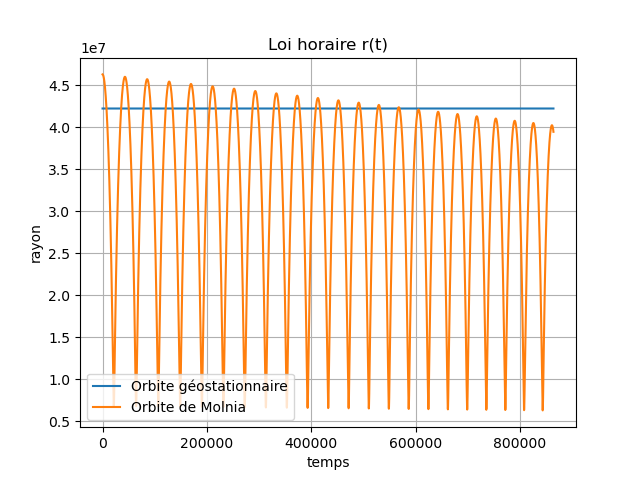

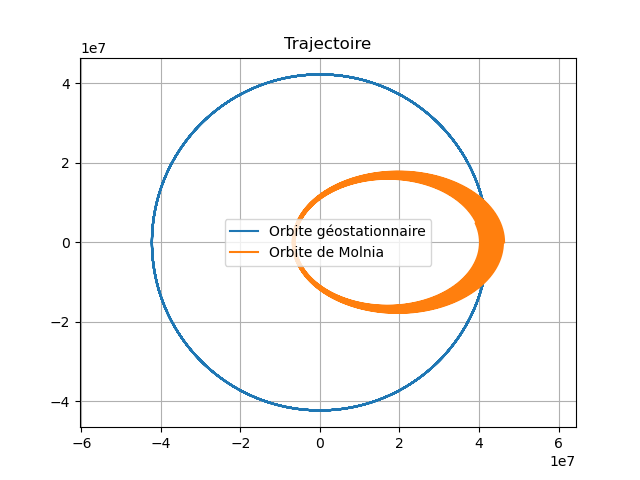

Le demi-grand axe de l'orbite géostationnaire calculée est  42241169.955
Le demi-petit axe de l'orbite géostationnaire calculée est  42241169.955
L'excentricité de l'orbite géostationnaire calculée est  0.000
Le demi-grand axe de l'orbite de Molnia calculée est  46300000.000
Le demi-petit axe de l'orbite de Molnia calculée est  6314886.380
L'excentricité de l'orbite de Molnia calculée est  0.991


In [5]:
plt.figure()
plt.title('Loi horaire r(t)')
plt.plot(np.linspace(0,T,N),r_geo,label='Orbite géostationnaire')
plt.plot(np.linspace(0,T,N),r_molnia,label='Orbite de Molnia')
plt.xlabel('temps')
plt.ylabel('rayon')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.title('Trajectoire')
plt.plot(np.array(r_geo)*np.cos(np.array(theta_geo)),np.array(r_geo)*np.sin(np.array(theta_geo)),label='Orbite géostationnaire')
plt.plot(np.array(r_molnia)*np.cos(np.array(theta_molnia)),np.array(r_molnia)*np.sin(np.array(theta_molnia)),label='Orbite de Molnia')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

print("Le demi-grand axe de l'orbite géostationnaire calculée est ", format(max(r_geo),"#.3f"))
print("Le demi-petit axe de l'orbite géostationnaire calculée est ", format(min(r_geo),"#.3f"))
print("L'excentricité de l'orbite géostationnaire calculée est ", format(np.sqrt(max(r_geo)**2-min(r_geo)**2)/max(r_geo),"#.3f"))
print("Le demi-grand axe de l'orbite de Molnia calculée est ", format(max(r_molnia),"#.3f"))
print("Le demi-petit axe de l'orbite de Molnia calculée est ", format(min(r_molnia),"#.3f"))
print("L'excentricité de l'orbite de Molnia calculée est ", format(np.sqrt(max(r_molnia)**2-min(r_molnia)**2)/max(r_molnia),"#.3f"))

La trajectoire de l'orbite de Molnia ne boucle pas parfaitement comme on peut le voir sur la courbe ci-dessus. C'est en grande partie dû à la dissipation numérique induite par l'estimation imparfaite des dérivées par la méthode d'Euler.

&nbsp;
Le schéma numérique `odeint` de `scipy` améliore grandement le résultat. On l'utilise sous forme vectorielle 
$$\dfrac{\text{d} X}{\text{d} t}=g(X,t)$$
où ici :
$$X=\left(\begin{array}{c}r \\ \theta \\ \dot{r} \\ \dot{\theta}\end{array}\right)\qquad g(X,t)=\left(\begin{array}{c}\dot{r} \\ \dot{\theta} \\ f(r)/m + r\dot{\theta}^2 \\ -2\dot{r}\dot{\theta}/r \end{array}\right)$$

&nbsp
Sous forme numérique cela donne : `X=[r,theta,dot_r,dot_theta]` et la fonction `deriv2(X,t)` doit renvoyer `[[X[2],X[3],F_centrale(X[0])/m + X[0]*X[3]**2, -2*X[2]*X[3]/X[0]]`.


In [6]:
r_theta_dotr_dottheta_0_geo=[r0,0.,0.,v0/r0]
r_theta_dotr_dottheta_0_molnia=[r1,0.,0.,v1/r1]

def deriv2(xv,t):
    return [xv[2], xv[3], F_centrale(xv[0])/m + xv[0]*xv[3]**2, -2*xv[2]*xv[3]/xv[0]]

r_theta_dotr_dottheta_geo = odeint(deriv2, r_theta_dotr_dottheta_0_geo, t)

r_geo_odeint = r_theta_dotr_dottheta_geo[:,0]
theta_geo_odeint = r_theta_dotr_dottheta_geo[:,1]
dotr_geo_odeint = r_theta_dotr_dottheta_geo[:,2]
dottheta_geo_odeint = r_theta_dotr_dottheta_geo[:,3]

r_theta_dotr_dottheta_molnia = odeint(deriv2, r_theta_dotr_dottheta_0_molnia, t)

r_molnia_odeint = r_theta_dotr_dottheta_molnia[:,0]
theta_molnia_odeint = r_theta_dotr_dottheta_molnia[:,1]
dotr_molnia_odeint = r_theta_dotr_dottheta_molnia[:,2]
dottheta_molnia_odeint = r_theta_dotr_dottheta_molnia[:,3]

On peut alors tracer les mêmes courbes et les comparer avec celles calculées par la méthode d'Euler.

/opt/anaconda3/lib/python3.8/site-packages/ipympl/backend_nbagg.py:223: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


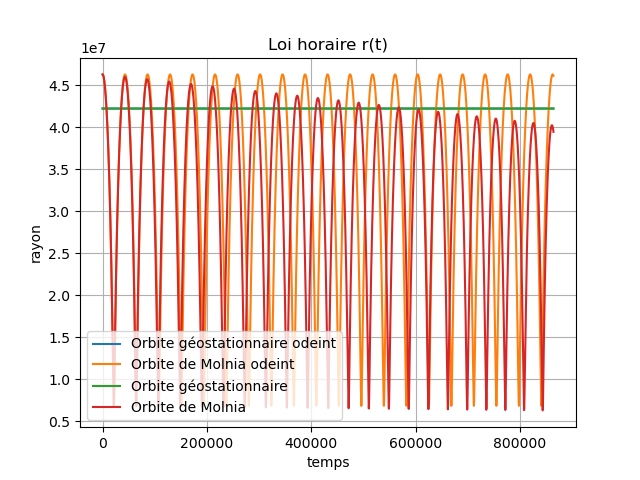

/opt/anaconda3/lib/python3.8/site-packages/ipympl/backend_nbagg.py:223: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


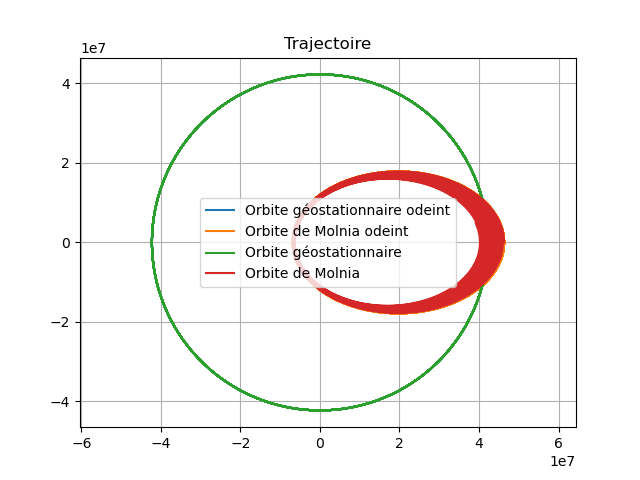

Le demi-grand axe de l'orbite géostationnaire calculée est  42241169.955
Le demi-grand axe de l'orbite géostationnaire calculée par odeint est  42241169.955
L'écart relatif entre les deux valeurs est  -0.000
Le demi-petit axe de l'orbite géostationnaire calculée est  42241169.955
Le demi-petit axe de l'orbite géostationnaire calculée par odeint est  42241169.955
L'écart relatif entre les deux valeurs est  0.000
L'excentricité de l'orbite géostationnaire calculée est  0.000
L'excentricité de l'orbite géostationnaire calculée par odeint est  0.000
Le demi-grand axe de l'orbite de Molnia calculée est  46300000.000
Le demi-grand axe de l'orbite de Molnia calculée par odeint est  46303398.146
L'écart relatif entre les deux valeurs est  -0.007
Le demi-petit axe de l'orbite de Molnia calculée est  6314886.380
Le demi-petit axe de l'orbite de Molnia calculée par odeint est  6853622.517
L'écart relatif entre les deux valeurs est  -7.861
L'excentricité de l'orbite de Molnia calculée est  0.991
L

In [7]:
plt.figure()
plt.title('Loi horaire r(t)')
plt.plot(t,r_geo_odeint,label='Orbite géostationnaire odeint')
plt.plot(t,r_molnia_odeint,label='Orbite de Molnia odeint')
plt.plot(np.linspace(0,T,N),r_geo,label='Orbite géostationnaire')
plt.plot(np.linspace(0,T,N),r_molnia,label='Orbite de Molnia')
plt.xlabel('temps')
plt.ylabel('rayon')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.title('Trajectoire')
plt.plot(np.array(r_geo_odeint)*np.cos(np.array(theta_geo_odeint)),np.array(r_geo_odeint)*np.sin(np.array(theta_geo_odeint)),label='Orbite géostationnaire odeint')
plt.plot(np.array(r_molnia_odeint)*np.cos(np.array(theta_molnia_odeint)),np.array(r_molnia_odeint)*np.sin(np.array(theta_molnia_odeint)),label='Orbite de Molnia odeint')
plt.plot(np.array(r_geo)*np.cos(np.array(theta_geo)),np.array(r_geo)*np.sin(np.array(theta_geo)),label='Orbite géostationnaire')
plt.plot(np.array(r_molnia)*np.cos(np.array(theta_molnia)),np.array(r_molnia)*np.sin(np.array(theta_molnia)),label='Orbite de Molnia')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

print("Le demi-grand axe de l'orbite géostationnaire calculée est ", format(max(r_geo),"#.3f"))
print("Le demi-grand axe de l'orbite géostationnaire calculée par odeint est ", format(max(r_geo_odeint),"#.3f"))
print("L'écart relatif entre les deux valeurs est ", format((max(r_geo)-max(r_geo_odeint))/max(r_geo_odeint)*100, "#.3f"))

print("Le demi-petit axe de l'orbite géostationnaire calculée est ", format(min(r_geo),"#.3f"))
print("Le demi-petit axe de l'orbite géostationnaire calculée par odeint est ", format(min(r_geo_odeint),"#.3f"))
print("L'écart relatif entre les deux valeurs est ", format((min(r_geo)-min(r_geo_odeint))/min(r_geo_odeint)*100, "#.3f"))

e_geo = np.sqrt(max(r_geo)**2-min(r_geo)**2)/max(r_geo)
e_geo_odeint = np.sqrt(max(r_geo_odeint)**2-min(r_geo_odeint)**2)/max(r_geo_odeint)
print("L'excentricité de l'orbite géostationnaire calculée est ", format(e_geo,"#.3f"))
print("L'excentricité de l'orbite géostationnaire calculée par odeint est ", format(e_geo_odeint,"#.3f"))
#print("L'écart relatif entre les deux valeurs est ", format((e_geo-e_geo_odeint)/e_geo_odeint*100, "#.3f"))

print("Le demi-grand axe de l'orbite de Molnia calculée est ", format(max(r_molnia),"#.3f"))
print("Le demi-grand axe de l'orbite de Molnia calculée par odeint est ", format(max(r_molnia_odeint),"#.3f"))
print("L'écart relatif entre les deux valeurs est ", format((max(r_molnia)-max(r_molnia_odeint))/max(r_molnia_odeint)*100, "#.3f"))

print("Le demi-petit axe de l'orbite de Molnia calculée est ", format(min(r_molnia),"#.3f"))
print("Le demi-petit axe de l'orbite de Molnia calculée par odeint est ", format(min(r_molnia_odeint),"#.3f"))
print("L'écart relatif entre les deux valeurs est ", format((min(r_molnia)-min(r_molnia_odeint))/min(r_molnia_odeint)*100, "#.3f"))

e_molnia = np.sqrt(max(r_molnia)**2-min(r_molnia)**2)/max(r_molnia)
e_molnia_odeint = np.sqrt(max(r_molnia_odeint)**2-min(r_molnia_odeint)**2)/max(r_molnia_odeint)
print("L'excentricité de l'orbite de Molnia calculée est ", format(e_molnia,"#.3f"))
print("L'excentricité de l'orbite de Molnia calculée par odeint est ", format(e_molnia_odeint,"#.3f"))
print("L'écart relatif entre les deux valeurs est ", format((e_molnia-e_molnia_odeint)/e_molnia_odeint*100, "#.3f"))



La période se déduit de la fréquence que l'on peut récupérer grâce à une transformation de Fourier.

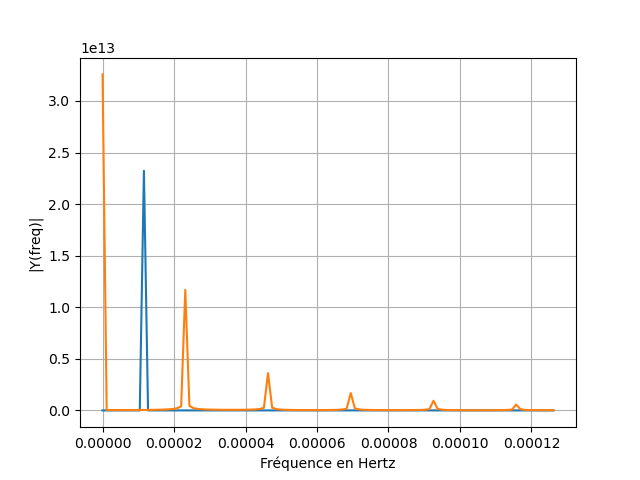

La période orbitale de l'orbite géostationnaire est :  1.000e+00 jour(s)
La période orbitale de l'orbite de Molnia est :  1.263e+01 heures(s)


In [8]:
# Tracé de la FFT
nb = 10000 # découpe du domaine fréquentiel affiché
Y1 = fft.fft(r_geo_odeint*np.cos(theta_geo_odeint),N) # fft computing and normalization
Y_geo = Y1[:int(N/nb)]

Y2 = fft.fft(r_molnia_odeint*np.cos(theta_molnia_odeint),N) # fft computing and normalization
Y_molnia = Y2[:int(N/nb)]


frq1 = np.arange(N)/(T)
frq_geo = frq1[:int(N/nb)] # one side frequency range

frq2 = np.arange(N)/(T)
frq_molnia = frq2[:int(N/nb)] # one side frequency range

plt.figure()
plt.plot(frq_geo,abs(Y_geo)) # plotting the spectrum
plt.plot(frq_molnia,abs(Y_molnia)) # plotting the spectrum
plt.grid(True)
#    plt.legend((r'Sans frottement', r'Avec frottement'))
plt.xlabel('Fréquence en Hertz')
plt.ylabel('|Y(freq)|')

plt.show()

max_value_geo = max(Y_geo)
max_index_geo = np.where(Y_geo == max_value_geo)

print("La période orbitale de l'orbite géostationnaire est : ", format(1/(24*3600*frq_geo[max_index_geo[0]][0]),"#.3e"), "jour(s)")

Y_molnia=Y_molnia[1:]
max_value_molnia = max(Y_molnia)
max_index_molnia = np.where(Y_molnia == max_value_molnia)

print("La période orbitale de l'orbite de Molnia est : ", format(1/(3600*frq_molnia[max_index_molnia[0]][0]),"#.3e"), "heures(s)")


